In [ ]:
import os, sys, torch
from torch_geometric.transforms import ToUndirected

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.load_graph_data import load_hetero_pt
from src.model_io import load_full_run

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')
    DEVICE = torch.device("cpu")
print('Using device:', DEVICE)
MODEL_REPO = 'model_6'
MODEL_SAVE_NAME = 'best_model.pt'
MODEL_PATH = MODEL_REPO + "/" + MODEL_SAVE_NAME

data = load_hetero_pt()
data = ToUndirected()(data)

keep = ['email', 'sender', 'url', 'domain', 'stem', 'body_cluster', 'email_domain', 'receiver']

keep_set = set(keep)

for ntype in list(data.node_types):
    if ntype not in keep_set:
        del data[ntype]

for et in list(data.edge_types):
    src, rel, dst = et
    if src not in keep_set or dst not in keep_set:
        del data[et]

model, predictor, loaders, splits, checkpoint = load_full_run(
    data=data,
    device=DEVICE,
    filename=MODEL_PATH,
)
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with val loss {checkpoint['val_loss']:.4f}")


Using device: cpu
Loaded checkpoint from epoch 20 with val loss 0.9189


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/load_graph_data.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_l

### AUROC / Average Precision
These metrics measure ranking quality for link prediction.
- AUROC: probability a random positive scores higher than a random negative (0.5 = random, 1.0 = perfect).
- Average Precision (AP): the weighted average of precision scores at all thresholds — it measures how well the model ranks true edges above false ones, rewarding confident and early correct predictions. (1.0 = perfect ranking, 0.5 = random, lower = poor ranking).


In [ ]:
from src.eval_link import collect_auroc_ap_scores
import pandas as pd
import os

scores = collect_auroc_ap_scores(DEVICE, model, predictor, loaders['test'])

print("TEST AUROC/AP per relation:")

for et, s in scores.items():

    print(et, s)

output_dir = os.path.join(PROJECT_ROOT, "models", MODEL_REPO)
os.makedirs(output_dir, exist_ok=True)
csv_path = os.path.join(output_dir, "auroc_ap_scores.csv")
results_df = (
    pd.DataFrame(scores)
    .T.reset_index()
    .rename(columns={"index": "relation"})
)
results_df.to_csv(csv_path, index=False)
print(f"Saved AUROC/AP results to {csv_path}")



TEST AUROC/AP per relation:
('email', 'has_sender', 'sender') {'auroc': 0.5143918332516673, 'ap': 0.19954611051380933}
('email', 'has_receiver', 'receiver') {'auroc': 0.9541158925442593, 'ap': 0.6379567074265112}
('email', 'has_url', 'url') {'auroc': 0.9529139803046881, 'ap': 0.6581124230284593}
('email', 'has_domain', 'domain') {'auroc': 0.954901478317962, 'ap': 0.7342904235097656}
('email', 'has_stem', 'stem') {'auroc': 0.9871358171143391, 'ap': 0.8962631807717227}
('sender', 'from_domain', 'email_domain') {'auroc': 0.8742029300465781, 'ap': 0.5138676565828172}
('email', 'has_body_cluster', 'body_cluster') {'auroc': 0.8790247849267688, 'ap': 0.419666926997956}
Saved AUROC/AP results to /Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/models/model_6/auroc_ap_scores.csv


### Recall@K (cosine)
For each source node (e.g. an email), rank all possible target nodes (e.g. URLs) by cosine similarity in embedding space. Recall@K is the fraction of source nodes that had at least one *true* connection among their top-K most similar targets. This tells us whether related nodes are close together in embedding space — useful for evaluating embeddings, especially for clustering or retrieval.


In [ ]:
from src.eval_link import topk_eval_with_splits
res_k1_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=1, use_dot=False)
print("\nRecall@1 (cosine) per relation:")
for et, m in res_k1_cos.items():
    print(et, m)

res_k10_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=10, use_dot=False)
print("\nRecall@10 (cosine) per relation:")
for et, m in res_k10_cos.items():
    print(et, m)

res_k50_cos = topk_eval_with_splits(DEVICE, model, splits, splits['sup_ets'], K=50, use_dot=False)
print("\nRecall@50 (cosine) per relation:")
for et, m in res_k50_cos.items():
    print(et, m)


Recall@1 (cosine) per relation:
('email', 'has_url', 'url') {'recall@K': 0.0019342360319569707, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 1034}
('email', 'has_domain', 'domain') {'recall@K': 0.0, 'MRR': 0.0, 'K': 1, 'n_eval_sources': 1614}
('email', 'has_stem', 'stem') {'recall@K': 0.002747252816334367, 'MRR': 1.0, 'K': 1, 'n_eval_sources': 1456}
('sender', 'from_domain', 'email_domain') {'recall@K': 0.0, 'MRR': 0.0, 'K': 1, 'n_eval_sources': 1171}
('url', 'rev_has_url', 'email') {'recall@K': 0.0, 'MRR': 0.0, 'K': 1, 'n_eval_sources': 785}
('domain', 'rev_has_domain', 'email') {'recall@K': 0.0, 'MRR': 0.0, 'K': 1, 'n_eval_sources': 1018}
('stem', 'rev_has_stem', 'email') {'recall@K': 0.0, 'MRR': 0.0, 'K': 1, 'n_eval_sources': 347}
('email_domain', 'rev_from_domain', 'sender') {'recall@K': 0.0, 'MRR': 0.0, 'K': 1, 'n_eval_sources': 844}

Recall@10 (cosine) per relation:
('email', 'has_url', 'url') {'recall@K': 0.028046421706676483, 'MRR': 0.30644500255584717, 'K': 10, 'n_eval_sources': 103

### Embedding Norm Diagnostics

Computes the L2 norms of email and URL embeddings from the training graph.

Very small norms may indicate vanishing representations (underfitting or over-regularization).

Very large norms can artificially inflate similarity scores and destabilize training.
Use this to check for numerical stability and detect whether embeddings are behaving as expected.

In [3]:
from src.embed import embed_with_graph

import torch
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])
email_vecs = h_train['email']
url_vecs = h_train['url']

print("Email embedding L2 norms:")
print(email_vecs.norm(dim=1).mean(), email_vecs.norm(dim=1).max())

print("URL embedding L2 norms:")
print(url_vecs.norm(dim=1).mean(), url_vecs.norm(dim=1).max())

Email embedding L2 norms:
tensor(1.) tensor(1.0000)
URL embedding L2 norms:
tensor(1.) tensor(1.0000)


### Link Score Distributions & Top-K Qualitative Check
Plots cosine similarity scores between true test edges and random negative pairs.  
A clean separation between the histograms indicates a strong link predictor.

Also retrieves top-K predicted neighbors for a given source node and checks whether any held-out true targets are recovered.
Note: low recall is expected for 1:1 relations like url→email.



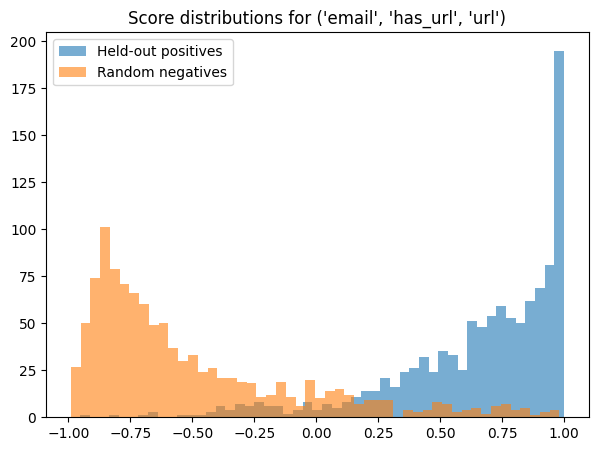

email_id: 2
Top-20 url ids: [1734, 2310, 2388, 1795, 1497, 1157, 1122, 2555, 1253, 2525, 2103, 1183, 1705, 318, 1448, 2462, 926, 925, 924, 923]
Is held-out true?: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [ ]:
import os, sys
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import topk_for_source

h_train = embed_with_graph(DEVICE, model, splits['train_graph'])

et = ('email', 'has_url', 'url')

S = F.normalize(h_train[et[0]], p=2, dim=1)
D = F.normalize(h_train[et[2]], p=2, dim=1)

S = S.cpu()
D = D.cpu()

pos = splits['test_pos'][et] 

pos_scores = (S[pos[0]] * D[pos[1]]).sum(dim=1).numpy()

g = torch.Generator().manual_seed(0)
neg_src = torch.randint(0, S.size(0), (len(pos_scores),), generator=g)
neg_dst = torch.randint(0, D.size(0), (len(pos_scores),), generator=g)
neg_scores = (S[neg_src] * D[neg_dst]).sum(dim=1).numpy()

plt.figure(figsize=(7, 5))
plt.hist(pos_scores, bins=50, alpha=0.6, label='Held-out positives')
plt.hist(neg_scores, bins=50, alpha=0.6, label='Random negatives')
plt.title(f"Score distributions for {et}")
plt.legend()
plt.show()

sources_with_pos = splits['test_pos'][et][0].unique()
src_id = int(sources_with_pos[0])

top_ids, top_scores = topk_for_source(h_train, et, src_id, K=20, cosine=True)
true_dests = set(
    splits['test_pos'][et][1][splits['test_pos'][et][0] == src_id].cpu().tolist()
)
print("email_id:", src_id)
print("Top-20 url ids:", top_ids)
print("Is held-out true?:", [i in true_dests for i in top_ids])


### Recall@K Curves**  
Visualizes how well the model retrieves true neighbors at increasing values of K using cosine similarity.  
Useful for comparing directions and choosing a K for retrieval/clustering.


Saved Recall@K plot to /Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/models/model_6/recall_at_k.png


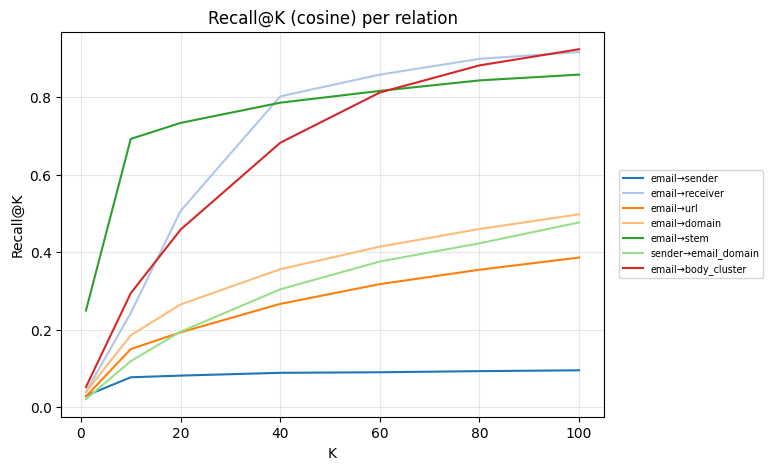

In [ ]:
import torch, matplotlib.pyplot as plt
import os, sys
PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.embed import embed_with_graph
from src.eval_link import collect_auroc_ap_scores, topk_eval_with_splits, topk_for_source, recall_at_k_mrr

K_list = [1, 10, 20, 40, 60, 80, 100]
h_train = embed_with_graph(DEVICE, model, splits['train_graph'])
ets = splits['sup_ets']

recall_curves = {et: [] for et in ets}
for et in ets:
    for K in K_list:
        res = recall_at_k_mrr(h_train, et, splits['test_pos'][et], K=K, use_dot=False)
        recall_curves[et].append(res['recall@K'])

plt.figure(figsize=(7,5))
colors = plt.cm.tab20(range(len(recall_curves)))
for (et, vals), color in zip(recall_curves.items(), colors):
    label = f"{et[0]}→{et[2]}"
    plt.plot(K_list, vals, label=label, color=color)
plt.xlabel("K"); plt.ylabel("Recall@K"); plt.title("Recall@K (cosine) per relation"); plt.grid(True, alpha=0.3)
plt.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1.02, 0.5))
output_dir = os.path.join(PROJECT_ROOT, "models", MODEL_REPO)
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "recall_at_k.png")
plt.savefig(plot_path, bbox_inches="tight")
print(f"Saved Recall@K plot to {plot_path}")
plt.show()


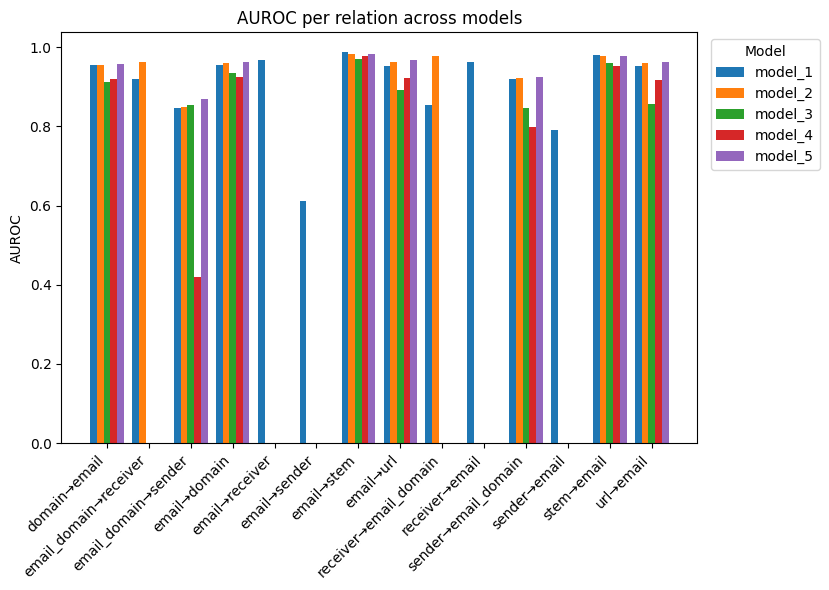

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

def _simplify_relation(rel: str) -> str:
    parts = rel.split("→")
    if len(parts) != 3:
        return rel
    src, relation, dst = parts
    if relation.startswith('rev_'):
        return f"{src}→{dst}"
    return f"{src}→{dst}"

models_root = Path(PROJECT_ROOT) / 'models'
model_dirs = sorted([p for p in models_root.iterdir() if p.is_dir() and p.name.startswith('model_')])

if not model_dirs:
    print(f'No model_* folders found in {models_root}')
else:
    frames = []
    missing = []
    for mdir in model_dirs:
        csv_path = mdir / 'auroc_ap_scores.csv'
        if not csv_path.exists():
            missing.append(mdir.name)
            continue
        df = pd.read_csv(csv_path)
        if 'relation' not in df.columns and {'level_0','level_1','level_2'}.issubset(df.columns):
            df['relation'] = df[['level_0','level_1','level_2']].astype(str).agg('→'.join, axis=1)
        df['model'] = mdir.name
        frames.append(df)
    if missing:
        print('Missing auroc_ap_scores.csv for:', ', '.join(missing))
    if not frames:
        print('No AUROC/AP CSVs to plot.')
    else:
        all_scores = pd.concat(frames, ignore_index=True)
        if 'relation' not in all_scores.columns:
            print('No relation information found in AUROC/AP CSVs (need relation or level_0/1/2).')
        else:
            pivot = all_scores.pivot(index='relation', columns='model', values='auroc')
            relations_full = list(pivot.index)
            relation_labels = [_simplify_relation(r) for r in relations_full]
            models = list(pivot.columns)
            x = range(len(relation_labels))
            total = len(models)
            width = 0.8 / max(total, 1)
            plt.figure(figsize=(max(8, len(relation_labels)*0.6), 6))
            for i, model in enumerate(models):
                offsets = [xi + (i - (total-1)/2)*width for xi in x]
                plt.bar(offsets, pivot[model], width=width, label=model)
            plt.xticks(list(x), relation_labels, rotation=45, ha='right')
            plt.ylabel('AUROC')
            plt.title('AUROC per relation across models')
            plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1.01, 1))
            plt.tight_layout()
            plt.show()


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/model_io.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, 

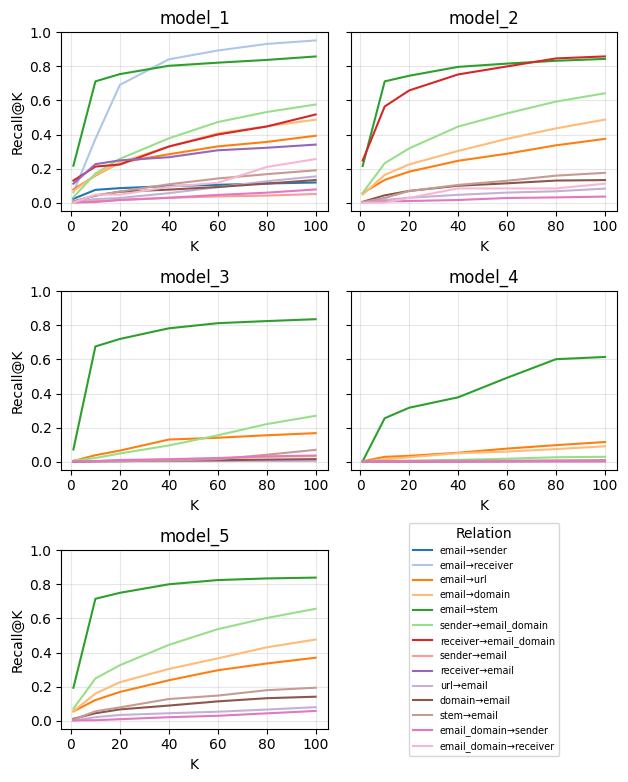

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os, sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.model_io import load_full_run
from src.embed import embed_with_graph
from src.eval_link import recall_at_k_mrr

model_ids = [1, 2, 3, 4, 5]
K_list = [1, 10, 20, 40, 60, 80, 100]

def compute_recall_curves(model, splits):
    h_train = embed_with_graph(DEVICE, model, splits['train_graph'])
    curves = {}
    for et in splits['sup_ets']:
        vals = []
        for K in K_list:
            res = recall_at_k_mrr(h_train, et, splits['test_pos'][et], K=K, use_dot=False)
            vals.append(res['recall@K'])
        curves[et] = vals
    return curves

model_results = []
all_relations = []
for mid in model_ids:
    fname = f"model_{mid}/best_model.pt"
    try:
        model_i, predictor_i, loaders_i, splits_i, checkpoint_i = load_full_run(data, device=DEVICE, filename=fname)
    except Exception as e:
        print(f'Failed to load {fname}: {e}')
        continue
    curves = compute_recall_curves(model_i, splits_i)
    model_results.append((f'model_{mid}', curves))
    for et in curves.keys():
        if et not in all_relations:
            all_relations.append(et)

if not model_results:
    print('No models loaded; skipping Recall@K comparison plot.')
else:
    cmap = plt.cm.tab20
    colors = {et: cmap(i % 20) for i, et in enumerate(all_relations)}
    labels = {et: f"{et[0]}→{et[2]}" for et in all_relations}

    cols = 2 if len(model_results) > 1 else 1
    rows = math.ceil(len(model_results) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.0*rows), sharey=True)
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.ravel()

    for ax, (mname, curves) in zip(axes, model_results):
        for et in all_relations:
            if et in curves:
                ax.plot(K_list, curves[et], color=colors[et], label=labels[et])
        ax.set_title(mname)
        ax.set_xlabel('K')
        ax.grid(True, alpha=0.3)
    if len(axes) > 0:
        axes[0].set_ylabel('Recall@K')
    for idx, ax in enumerate(axes):
        if idx % cols == 0:
            ax.set_ylabel('Recall@K')

    handles, leg_labels = [], []
    for et in all_relations:
        handles.append(plt.Line2D([], [], color=colors[et]))
        leg_labels.append(labels[et])

    legend_index = rows*cols - 1
    legend_ax = axes[legend_index] if legend_index < len(axes) else None
    if legend_ax is not None:
        legend_ax.axis('off')

    for idx, ax in enumerate(axes):
        if idx >= len(model_results) and idx != legend_index:
            ax.axis('off')

    if legend_ax is not None:
        legend_ax.legend(handles, leg_labels, title='Relation', loc='center', fontsize='x-small')
    else:
        fig.legend(handles, leg_labels, title='Relation', loc='center right', bbox_to_anchor=(1.02, 0.5), ncol=1, fontsize='x-small')
    fig.tight_layout(rect=[0, 0.02, 1, 0.9])
    plt.show()
